Introduction

We will evaluate global health and hospital data to analyze the relationship between ease of access to healthcare facilities and various health outcomes (such as mortality rate, disease prevalence, and disease burden).

To do this, we will cluster countries based on their level of healthcare access. Once clusters are formed, we will apply linear regression to examine how healthcare access relates to different health outcomes within and across these groups.

Finally, we will briefly explore a few additional insights in the dataset, such as the relationship between treatment costs and recovery rates.

____________________________________________________________________________________________________________________________________________________

Pip Installs & Imports

In [14]:
pip install pandas numpy scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

____________________________________________________________________________________________________________________________________________________

Dataframe Creation & Preprocessing

In [16]:
df = pd.read_csv("Global Health Statistics.csv")
for x in df.columns:
    print(f"{x:35}  →  {df[x].dtype}")

Country                              →  object
Year                                 →  int64
Disease Name                         →  object
Disease Category                     →  object
Prevalence Rate (%)                  →  float64
Incidence Rate (%)                   →  float64
Mortality Rate (%)                   →  float64
Age Group                            →  object
Gender                               →  object
Population Affected                  →  int64
Healthcare Access (%)                →  float64
Doctors per 1000                     →  float64
Hospital Beds per 1000               →  float64
Treatment Type                       →  object
Average Treatment Cost (USD)         →  int64
Availability of Vaccines/Treatment   →  object
Recovery Rate (%)                    →  float64
DALYs                                →  int64
Improvement in 5 Years (%)           →  float64
Per Capita Income (USD)              →  int64
Education Index                      →  float64
Urbanizat

Let’s convert our object-type columns to the category data type. These columns contain repeated labels from a fixed set of values, so using the category type reduces memory usage and speeds up operations such as grouping, filtering, and sorting.

In [17]:
df["Average Treatment Cost (USD)"] = df["Average Treatment Cost (USD)"].astype(float)
df["DALYs"] = df["DALYs"].astype(float)
df["Per Capita Income (USD)"] = df["Per Capita Income (USD)"].astype(float)

category_cols = [
    "Disease Name", "Disease Category", "Age Group", "Gender",
    "Treatment Type", "Availability of Vaccines/Treatment"
]

df[category_cols] = df[category_cols].astype("category")

for x in df.columns:
    print(f"{x:35}  →  {df[x].dtype}")

Country                              →  object
Year                                 →  int64
Disease Name                         →  category
Disease Category                     →  category
Prevalence Rate (%)                  →  float64
Incidence Rate (%)                   →  float64
Mortality Rate (%)                   →  float64
Age Group                            →  category
Gender                               →  category
Population Affected                  →  int64
Healthcare Access (%)                →  float64
Doctors per 1000                     →  float64
Hospital Beds per 1000               →  float64
Treatment Type                       →  category
Average Treatment Cost (USD)         →  float64
Availability of Vaccines/Treatment   →  category
Recovery Rate (%)                    →  float64
DALYs                                →  float64
Improvement in 5 Years (%)           →  float64
Per Capita Income (USD)              →  float64
Education Index                      → 

In [18]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

df.head(10)

,Country,Year,Disease Name,Disease Category,Prevalence Rate (%),Incidence Rate (%),Mortality Rate (%),Age Group,Gender,Population Affected,Healthcare Access (%),Doctors per 1000,Hospital Beds per 1000,Treatment Type,Average Treatment Cost (USD),Availability of Vaccines/Treatment,Recovery Rate (%),DALYs,Improvement in 5 Years (%),Per Capita Income (USD),Education Index,Urbanization Rate (%)
0,Italy,2013,Malaria,Respiratory,0.95,1.55,8.42,0-18,Male,471007,57.74,3.34,7.58,Medication,21064.0,No,91.82,4493.0,2.16,16886.0,0.79,86.02
1,France,2002,Ebola,Parasitic,12.46,8.63,8.75,61+,Male,634318,89.21,1.33,5.11,Surgery,47851.0,Yes,76.65,2366.0,4.82,80639.0,0.74,45.52
2,Turkey,2015,COVID-19,Genetic,0.91,2.35,6.22,36-60,Male,154878,56.41,4.07,3.49,Vaccination,27834.0,Yes,98.55,41.0,5.81,12245.0,0.41,40.20
3,Indonesia,2011,Parkinson's Disease,Autoimmune,4.68,6.29,3.99,0-18,Other,446224,85.20,3.18,8.44,Surgery,144.0,Yes,67.35,3201.0,2.22,49336.0,0.49,58.47
4,Italy,2013,Tuberculosis,Genetic,0.83,13.59,7.01,61+,Male,472908,67.00,4.61,5.90,Medication,8908.0,Yes,50.06,2832.0,6.93,47701.0,0.50,48.14
5,Saudi Arabia,2011,Dengue,Bacterial,10.99,6.49,4.64,61+,Female,479234,98.41,3.50,0.62,Therapy,42671.0,Yes,93.17,416.0,9.83,29597.0,0.46,56.50
6,USA,2013,Malaria,Cardiovascular,18.42,6.33,9.33,61+,Female,289931,90.03,3.16,3.31,Surgery,15579.0,No,92.80,4535.0,0.89,60027.0,0.70,20.48
7,Nigeria,2007,Tuberculosis,Neurological,3.48,5.71,1.21,0-18,Female,393296,75.60,0.54,3.54,Medication,15744.0,Yes,65.45,4584.0,9.81,23222.0,0.46,66.49
8,Italy,2000,Rabies,Chronic,15.59,4.74,6.38,19-35,Female,253110,87.87,4.56,5.84,Therapy,7669.0,Yes,59.23,2253.0,9.92,30849.0,0.55,41.27
9,Australia,2006,Cholera,Chronic,10.12,2.08,6.00,61+,Male,174143,95.90,4.63,6.01,Medication,9468.0,Yes,93.21,4694.0,2.96,68856.0,0.90,83.30


Here we see a preview of our data, with each record representing a country. Everything looks good, so let's check for null values so we can handle them accordingly.

In [19]:
df.isnull().sum()

Country                               0
Year                                  0
Disease Name                          0
Disease Category                      0
Prevalence Rate (%)                   0
Incidence Rate (%)                    0
Mortality Rate (%)                    0
Age Group                             0
Gender                                0
Population Affected                   0
Healthcare Access (%)                 0
Doctors per 1000                      0
Hospital Beds per 1000                0
Treatment Type                        0
Average Treatment Cost (USD)          0
Availability of Vaccines/Treatment    0
Recovery Rate (%)                     0
DALYs                                 0
Improvement in 5 Years (%)            0
Per Capita Income (USD)               0
Education Index                       0
Urbanization Rate (%)                 0
dtype: int64

No nulls, so we can move on!

____________________________________________________________________________________________________________________________________________________

Clustering

In [20]:
access_cols = [
    "Healthcare Access (%)",
    "Doctors per 1000",
    "Hospital Beds per 1000" 
]

X = df[access_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


k = 5   #5 clusters is a random start
kmeans = KMeans(n_clusters=k, random_state=0)

clusters = kmeans.fit_predict(X_scaled)
df["Cluster"] = clusters

Here we assign clusters based on the features that describe each country's access to healthcare. We start with an initial choice of five clusters, but we will use inertia and silhouette scores to determine the optimal number of clusters.

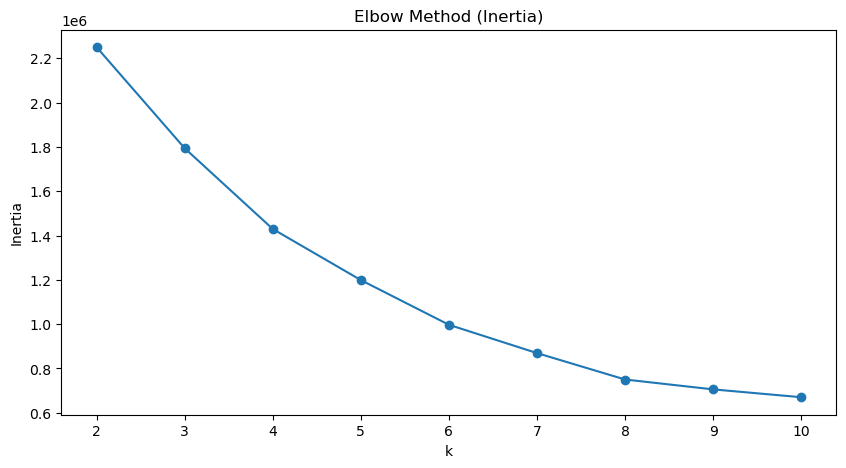

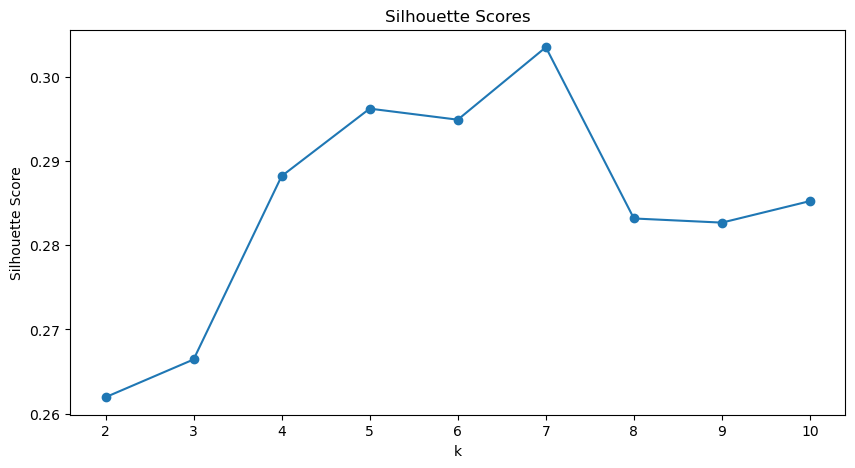

In [21]:
inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=5)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)

    # silhouette on subsample if dataset large
    if len(X_scaled) > 300:
        from sklearn.utils import resample
        sample = resample(X_scaled, n_samples=200, random_state=0)
        sil = silhouette_score(sample, kmeans.fit_predict(sample))
    else:
        sil = silhouette_score(X_scaled, labels)

    silhouettes.append(sil)

# Plot inertia
plt.figure(figsize=(10,5))
plt.plot(K_range, inertias, marker='o')
plt.xticks(K_range)
plt.title("Elbow Method (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

# Plot silhouette
plt.figure(figsize=(10,5))
plt.plot(K_range, silhouettes, marker='o')
plt.xticks(K_range)
plt.title("Silhouette Scores")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.show()

We'll stick with our initial choice of five clusters because it offers a strong balance between detail and interpretability. The inertia curve shows an elbow around four to five clusters, meaning that additional clusters provide diminishing returns. Silhouette scores also remain solid in this range, suggesting that the clusters are well-separated and meaningful. Using five clusters gives us enough nuance to compare different levels of healthcare access without overfitting or creating overly small, noisy groups.

In [22]:
cluster_means = df.groupby("Cluster")[[
    "Healthcare Access (%)",
    "Doctors per 1000",
    "Hospital Beds per 1000"
]].mean()

cluster_means

,Healthcare Access (%),Doctors per 1000,Hospital Beds per 1000
Cluster,,,
0,74.124779,1.523559,2.778372
1,86.803602,1.703987,7.464762
2,88.504964,3.921534,5.072592
3,61.970895,2.815700,7.832930
4,63.137912,3.805486,3.012530


Now that we have our cluster statistics, let's interpret and name our clusters:


Cluster 0: Limited, Moderate Access – Moderate access but limited staffing and bed capacity.

Cluster 1: Bed-Lopsided, High Access – Strong access driven mainly by hospital bed availability, but lower physician density.

Cluster 2: Well-Rounded, High Access – Top-tier access with strong staffing and well-developed hospital systems.

Cluster 3: Bed-Lopsided, Low Access – High hospital bed capacity, but population-level access and workforce coverage remain low.

Cluster 4: Doctor-Lopsided, Low Access – Strong physician workforce but lower overall access and weaker hospital infrastructure.

In [24]:
cluster_labels = {
    0: "Limited, Moderate Access",
    1: "Bed-Lopsided, High Access",
    2: "Well-Rounded, High Access",
    3: "Bed-Lopsided, Low Access",
    4: "Doctor-Lopsided, Low Access"
}

df["Cluster_Name"] = df["Cluster"].map(cluster_labels)

df.head(6)

,Country,Year,Disease Name,Disease Category,Prevalence Rate (%),Incidence Rate (%),Mortality Rate (%),Age Group,Gender,Population Affected,Healthcare Access (%),Doctors per 1000,Hospital Beds per 1000,Treatment Type,Average Treatment Cost (USD),Availability of Vaccines/Treatment,Recovery Rate (%),DALYs,Improvement in 5 Years (%),Per Capita Income (USD),Education Index,Urbanization Rate (%),Cluster,Cluster_Name
0,Italy,2013,Malaria,Respiratory,0.95,1.55,8.42,0-18,Male,471007,57.74,3.34,7.58,Medication,21064.0,No,91.82,4493.0,2.16,16886.0,0.79,86.02,3,"Bed-Lopsided, Low Access"
1,France,2002,Ebola,Parasitic,12.46,8.63,8.75,61+,Male,634318,89.21,1.33,5.11,Surgery,47851.0,Yes,76.65,2366.0,4.82,80639.0,0.74,45.52,1,"Bed-Lopsided, High Access"
2,Turkey,2015,COVID-19,Genetic,0.91,2.35,6.22,36-60,Male,154878,56.41,4.07,3.49,Vaccination,27834.0,Yes,98.55,41.0,5.81,12245.0,0.41,40.20,4,"Doctor-Lopsided, Low Access"
3,Indonesia,2011,Parkinson's Disease,Autoimmune,4.68,6.29,3.99,0-18,Other,446224,85.20,3.18,8.44,Surgery,144.0,Yes,67.35,3201.0,2.22,49336.0,0.49,58.47,1,"Bed-Lopsided, High Access"
4,Italy,2013,Tuberculosis,Genetic,0.83,13.59,7.01,61+,Male,472908,67.00,4.61,5.90,Medication,8908.0,Yes,50.06,2832.0,6.93,47701.0,0.50,48.14,4,"Doctor-Lopsided, Low Access"
5,Saudi Arabia,2011,Dengue,Bacterial,10.99,6.49,4.64,61+,Female,479234,98.41,3.50,0.62,Therapy,42671.0,Yes,93.17,416.0,9.83,29597.0,0.46,56.50,2,"Well-Rounded, High Access"


Now that each country has been assigned to a cluster, we can extract general insights.

________________________________________________________________________________________________________________________

Linear Regression